#This is my CE888 Project 2 building a CNN for Image Classification on the FLAME Dataset.

In [ ]:
#import libraries 
import pandas as pd
import numpy as np
import os
import cv2
import glob
import seaborn as sns
import plotly.figure_factory as ff
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input
from keras.layers import Dropout
from keras import models
from tensorflow.keras import Model
from keras import optimizers
from tensorflow.keras.applications import VGG16
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#unzip test file 
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Test.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

#unzip training file 
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Training.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done
done


In [ ]:
#set batch size, image size 
batch_size = 32
img_height = 224
img_width = 224
train_dir = '/content/Training'
test_dir = '/content/Test'

#load images into objects locally (to display some images)
train1 = tf.keras.preprocessing.image_dataset_from_directory(
     train_dir,
     labels='inferred',
     color_mode="rgb",
     batch_size=32,
     image_size= (img_height, img_width),
     shuffle=True,
     seed=123,
     validation_split=0.2,
     subset="training"
)

val1 = tf.keras.preprocessing.image_dataset_from_directory(
     train_dir,
     labels='inferred',
     color_mode="rgb",
     batch_size=32,
     image_size= (img_height, img_width),
     shuffle=False,
     seed=123,
     validation_split=0.2,
     subset="validation"
)

test1 = tf.keras.preprocessing.image_dataset_from_directory(
     test_dir,
     labels='inferred',
     color_mode="rgb",
     batch_size=32,
     image_size= (img_height, img_width),
     shuffle=False,
     seed=123
)

Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.
Found 8617 files belonging to 2 classes.


In [ ]:
#get labels from test set 
y = np.concatenate([y for x, y in test1], axis=0)

In [ ]:
#view class names 
class_names = train1.class_names
print(class_names)

['Fire', 'No_Fire']


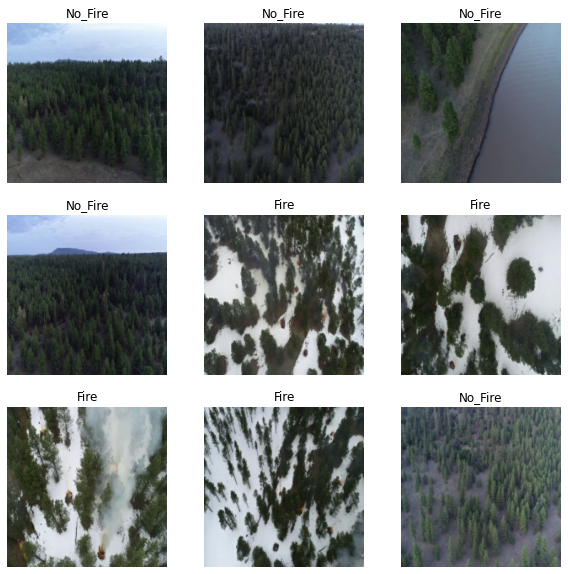

In [ ]:
#visualise some example images from training set 
plt.figure(figsize=(10, 10))
for images, labels in train1.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Load images for class counts

In [ ]:
#load images in list form to create x_train, y_train, x_test, y_test
x_train = []
path = "/content/Training/No_Fire/*.jpg"
for file in glob.glob(path):
    a=cv2.imread(file)
    x_train.append(a)

y_train = []
path = "/content/Training/Fire/*.jpg"
for file in glob.glob(path):
    a=cv2.imread(file)
    res = cv2.resize(a, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    image = cv2.normalize(res, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    y_train.append(a)

x_test = []
path = "/content/Test/No_Fire/*.jpg"
for file in glob.glob(path):
    a=cv2.imread(file)
    x_test.append(a)

y_test = []
path = "/content/Test/Fire/*.jpg"
for file in glob.glob(path):
    a=cv2.imread(file)
    y_test.append(a)

In [ ]:
#as array
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
#create df for classes information on train/test set 
classes = pd.DataFrame({
    'Class' : ['Training No Fire', 'Training Fire', 'Test No Fire', 'Test Fire'],
    'Total' : [len(x_train), len(y_train), len(x_test), len(y_test)]
})

fig =  ff.create_table(classes)
fig.update_layout(
    autosize=False,
    width=500,
    height=200,
)
fig.show()


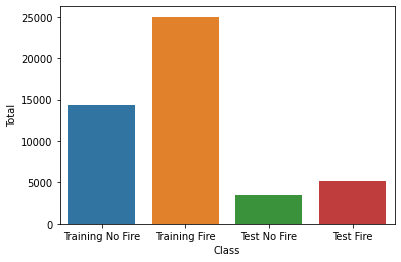

In [ ]:
#barplot
sns.barplot(x= classes['Class'], y=classes['Total'], data = classes)

##Set weights to deal with observed imbalance in classes 

In [ ]:
#calculate/set class weights to help deal with imbalanced classes in the training data 
no_fire_weight = len(y_train)/len(x_train)
print(no_fire_weight)
class_weights={1: no_fire_weight, 0 : 1}

1.742564602632862


## I will now import the pretrained RESnet50 CNN and use call backs and transfer learning to retrain the weights on the output layer for this specific task.

In [ ]:
#import and resize images to suitable size 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=[0.7,1.3],
                                   zoom_range=[0.7,1.0],
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_resize = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='binary',
                                              subset='training')

val_resize = val_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    shuffle=False,
                                                    class_mode='binary',
                                              subset='validation')

test_resize = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        shuffle=False,
                                                        class_mode='binary')

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [ ]:
#set size etc 
IMG_SIZE = 224
# LR = 1e-4
img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
#import and compile model 
Model.ResNet50 = tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=img_input,
    input_shape=None, pooling=None, classes=1000
)


# Model.ResNet50.summary()

In [ ]:
last_layer = Model.ResNet50.get_layer('avg_pool').output
out = Dense(1, activation='sigmoid', name='output')(last_layer)  ## 2 classes
Model.ResNet50 = Model(img_input, out)

for layer in Model.ResNet50.layers[:-1]:
	layer.trainable = False

for i, layer in enumerate(Model.ResNet50.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [ ]:
Model.ResNet50.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
]


# Model.ResNet50.summary()

In [ ]:
history = Model.ResNet50.fit(
  train_resize,
  validation_data=val_resize,
  epochs=3, 
  callbacks=my_callbacks,
  class_weight=class_weights
)

Epoch 1/3
985/985 [==============================] - 472s 475ms/step - loss: 0.5315 - binary_accuracy: 0.8304 - val_loss: 0.1540 - val_binary_accuracy: 0.9265
Epoch 2/3
985/985 [==============================] - 455s 462ms/step - loss: 0.3708 - binary_accuracy: 0.8896 - val_loss: 0.1140 - val_binary_accuracy: 0.9822
Epoch 3/3
985/985 [==============================] - 454s 461ms/step - loss: 0.3265 - binary_accuracy: 0.9048 - val_loss: 0.1500 - val_binary_accuracy: 0.9536


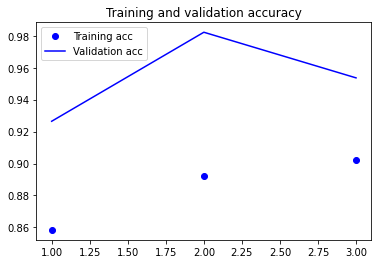

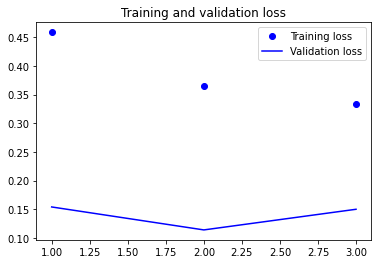

In [ ]:
#map training and validation loss/accuracy 
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
ResNet50_results = Model.ResNet50.evaluate(test_resize)
print("test loss, test acc:", ResNet50_results)

Evaluate on test data
270/270 [==============================] - 22s 81ms/step - loss: 0.7028 - binary_accuracy: 0.6720
test loss, test acc: [0.7028050422668457, 0.6720436215400696]


In [ ]:
#Confution Matrix and Classification Report
predictions = Model.ResNet50.predict(test_resize)
Y_pred = predictions > 0.5
test_acc = accuracy_score(test_resize.classes, Y_pred)

# print('Confusion Matrix')
# print(confusion_matrix(test_resize.classes, Y_pred))

# print('Classification Report')
# target_names = ['Fire', 'No_Fire']
# print(classification_report(test_resize.classes, Y_pred, target_names=target_names))


precision, recall, f1score, _ = precision_recall_fscore_support(test_resize.classes, Y_pred, average='binary')

auc = roc_auc_score(test_resize.classes, Y_pred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)
#create df
classification_table = pd.DataFrame({
    'Metric' : ['Train Accuracy', 'Val Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Score'  : [round(acc[-1]*100,2), round(val_acc[-1]*100,2), round(test_acc*100,2), round(precision*100,2), round(recall*100,2), round(f1score*100,2), round(auc*100,2)]
})

#make table 
fig =  ff.create_table(classification_table)
fig.update_layout(
    autosize=False,
    width=500,
    height=200,
)
fig.show()

Train Accuracy:	 0.9021936058998108
Val Accuracy:	 0.9536449313163757
Test Accuracy:	 0.6720436346756412
Precision:	 0.6209319526627219
Recall:		 0.48247126436781607
F1 Score:	 0.5430142302716687
AUC:		 0.6414692315609763


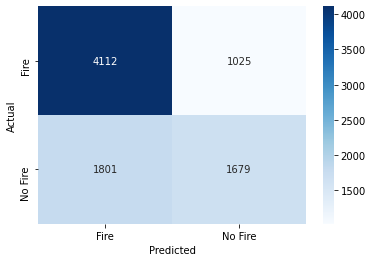

In [ ]:
#create confusion matrix 
con = confusion_matrix(test_resize.classes, Y_pred)
con

#visualise matrix 
sns.heatmap(con, cmap="Blues", annot=True, fmt='g', xticklabels=('Fire', 'No Fire'), yticklabels=('Fire', 'No Fire'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## I will now import the pretained ResNet101V2, I will reatrian the output layer to this task. 

In [ ]:
#import model
Model.ResNet101V2 = tf.keras.applications.ResNet101V2(
    include_top=True, weights='imagenet', input_tensor=img_input,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

# Model.ResNet101V2.summary()

In [ ]:
#make layers trainable/display
last_layer = Model.ResNet101V2.get_layer('avg_pool').output
out = Dense(1, activation='sigmoid', name='output')(last_layer)  ## 2 classes
Model.ResNet101V2 = Model(img_input, out)

for layer in Model.ResNet101V2.layers[:-1]:
	layer.trainable = False

for i, layer in enumerate(Model.ResNet101V2.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 pool1_pad - False
4 pool1_pool - False
5 conv2_block1_preact_bn - False
6 conv2_block1_preact_relu - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_pad - False
11 conv2_block1_2_conv - False
12 conv2_block1_2_bn - False
13 conv2_block1_2_relu - False
14 conv2_block1_0_conv - False
15 conv2_block1_3_conv - False
16 conv2_block1_out - False
17 conv2_block2_preact_bn - False
18 conv2_block2_preact_relu - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_pad - False
23 conv2_block2_2_conv - False
24 conv2_block2_2_bn - False
25 conv2_block2_2_relu - False
26 conv2_block2_3_conv - False
27 conv2_block2_out - False
28 conv2_block3_preact_bn - False
29 conv2_block3_preact_relu - False
30 conv2_block3_1_conv - False
31 conv2_block3_1_bn - False
32 conv2_block3_1_relu - False
33 conv2_block3_2_pad - False
3

In [ ]:
#visaulise model 
Model.ResNet101V2.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]


# Model.ResNet101V2.summary()

In [ ]:
#train model 
history = Model.ResNet101V2.fit(
  train_resize,
  validation_data=val_resize,
  epochs=3, 
  callbacks=my_callbacks,
  class_weight=class_weights
)

Epoch 1/3
985/985 [==============================] - 478s 478ms/step - loss: 0.2317 - binary_accuracy: 0.9244 - val_loss: 0.1879 - val_binary_accuracy: 0.9512
Epoch 2/3
985/985 [==============================] - 458s 465ms/step - loss: 0.0628 - binary_accuracy: 0.9839 - val_loss: 0.2703 - val_binary_accuracy: 0.9453
Epoch 3/3
985/985 [==============================] - 461s 468ms/step - loss: 0.0484 - binary_accuracy: 0.9868 - val_loss: 0.2402 - val_binary_accuracy: 0.9484


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
ResNet101v2_results = Model.ResNet101V2.evaluate(test_resize)
print("test loss, test acc:", ResNet101v2_results)

Evaluate on test data
270/270 [==============================] - 25s 91ms/step - loss: 0.9465 - binary_accuracy: 0.6932
test loss, test acc: [0.9465214610099792, 0.6931646466255188]


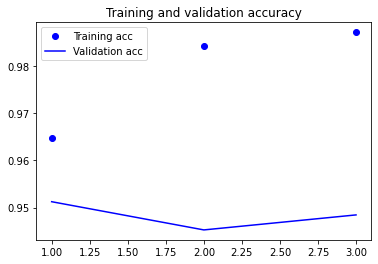

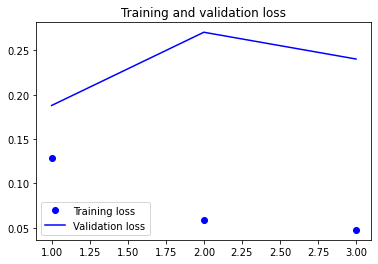

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Confution Matrix and Classification Report
Y_pred = Model.ResNet101V2.predict(test_resize)
Y_pred = Y_pred > 0.5
test_acc = accuracy_score(test_resize.classes, Y_pred)
print('Confusion Matrix')
print(confusion_matrix(test_resize.classes, Y_pred))
print('Classification Report')
target_names = ['Fire', 'No_Fire']
print(classification_report(test_resize.classes, Y_pred, target_names=target_names))

precision, recall, f1score, _ = precision_recall_fscore_support(test_resize.classes, Y_pred, average='binary')

auc = roc_auc_score(test_resize.classes, Y_pred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

#Create table classification table
classification_table = pd.DataFrame({
    'Metric' : ['Train Accuracy', 'Val Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Score'  : [round(acc[-1]*100,2), round(val_acc[-1]*100,2), round(test_acc*100,2), round(precision*100,2), round(recall*100,2), round(f1score*100,2), round(auc*100,2)]
})
#make table 
fig =  ff.create_table(classification_table)
fig.update_layout(
    autosize=False,
    width=500,
    height=200,
)
fig.show()

Confusion Matrix
[[4360  777]
 [1867 1613]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.70      0.85      0.77      5137
     No_Fire       0.67      0.46      0.55      3480

    accuracy                           0.69      8617
   macro avg       0.69      0.66      0.66      8617
weighted avg       0.69      0.69      0.68      8617

Train Accuracy:	 0.9870797991752625
Val Accuracy:	 0.9484378695487976
Test Accuracy:	 0.6931646744806778
Precision:	 0.6748953974895398
Recall:		 0.4635057471264368
F1 Score:	 0.5495741056218058
AUC:		 0.6561250752373473


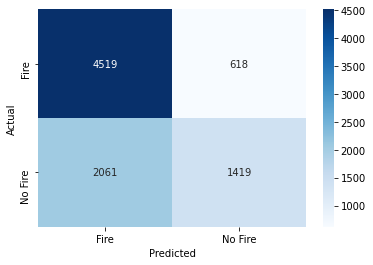

In [ ]:
con = confusion_matrix(test_resize.classes, Y_pred)
con
sns.heatmap(con, cmap="Blues", annot=True, fmt='g', xticklabels=('Fire', 'No Fire'), yticklabels=('Fire', 'No Fire'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## I will now use the VGG16 model on the dataset and use call backs and transfer learning to retrain the weights on the output layer 

In [ ]:
#import model
model_vgg16 = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling='avg',
    classes=1000,
    classifier_activation="softmax")

# model_vgg16.summary()

In [ ]:
#make layers trainable/untrainable
last_layer = model_vgg16.get_layer('fc2').output
out = Dense(1, activation='sigmoid', name='output')(last_layer)  ## 2 classes
model_vgg16 = Model(img_input, out)

for layer in model_vgg16.layers[:-8]:
	layer.trainable = False

# model_vgg16.summary()

In [ ]:
for i, layer in enumerate(model_vgg16.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_3 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - True
16 block5_conv2 - True
17 block5_conv3 - True
18 block5_pool - True
19 flatten - True
20 fc1 - True
21 fc2 - True
22 output - True


In [ ]:
#Comppile model 
model_vgg16.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]



In [ ]:
#Train model
history = model_vgg16.fit(train_resize, 
                               batch_size=batch_size,
                               epochs=3, 
                               validation_data=val_resize,
                               callbacks=my_callbacks,
                               class_weight=class_weights)

Epoch 1/3
985/985 [==============================] - 398s 403ms/step - loss: 2.3935 - binary_accuracy: 0.9016 - val_loss: 0.3925 - val_binary_accuracy: 0.9176
Epoch 2/3
985/985 [==============================] - 396s 402ms/step - loss: 0.1836 - binary_accuracy: 0.9613 - val_loss: 0.4241 - val_binary_accuracy: 0.9348
Epoch 3/3
985/985 [==============================] - 396s 402ms/step - loss: 0.0749 - binary_accuracy: 0.9836 - val_loss: 0.5085 - val_binary_accuracy: 0.9582


In [ ]:
#evaluate model 
predict = model_vgg16.predict(test_resize)
predict = np.round(predict)
#calculate accuracy 
vgg16_accuracy = round(metrics.accuracy_score(y, predict) * 100, 2)
print(vgg16_accuracy)

71.81


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
vgg16_results = model_vgg16.evaluate(test_resize)
print("test loss, test acc:", vgg16_results)

Evaluate on test data
270/270 [==============================] - 19s 69ms/step - loss: 3.4469 - binary_accuracy: 0.7181
test loss, test acc: [3.4468681812286377, 0.7181153297424316]


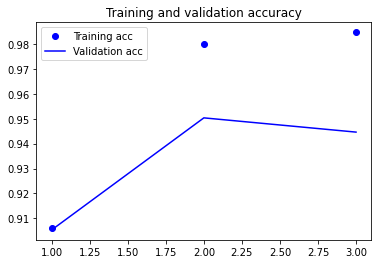

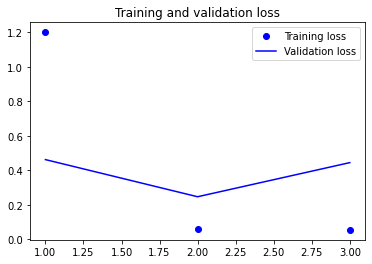

In [ ]:
#create graph for training/validation loss/accuracy 
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_vgg16.predict(test_resize)
Y_pred = Y_pred > 0.5
test_acc = accuracy_score(test_resize.classes, Y_pred)
print('Confusion Matrix')
print(confusion_matrix(test_resize.classes, Y_pred))
print('Classification Report')
target_names = ['Fire', 'No_Fire']
print(classification_report(test_resize.classes, Y_pred, target_names=target_names))

precision, recall, f1score, _ = precision_recall_fscore_support(test_resize.classes, Y_pred, average='binary')

auc = roc_auc_score(test_resize.classes, Y_pred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

#Create table classification table
classification_table = pd.DataFrame({
    'Metric' : ['Train Accuracy', 'Val Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Score'  : [acc[-1]*100, val_acc[-1]*100, test_acc*100, precision*100, recall*100, f1score*100, auc*100]
})

#create table of results 
fig =  ff.create_table(classification_table)
fig.update_layout(
    autosize=False,
    width=500,
    height=200,
)
fig.show()


Confusion Matrix
[[4126 1011]
 [1136 2344]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.78      0.80      0.79      5137
     No_Fire       0.70      0.67      0.69      3480

    accuracy                           0.75      8617
   macro avg       0.74      0.74      0.74      8617
weighted avg       0.75      0.75      0.75      8617

Train Accuracy:	 0.9846988916397095
Val Accuracy:	 0.9446278810501099
Test Accuracy:	 0.7508413601021237
Precision:	 0.6986587183308495
Recall:		 0.6735632183908046
F1 Score:	 0.6858814923189466
AUC:		 0.7383778716053693


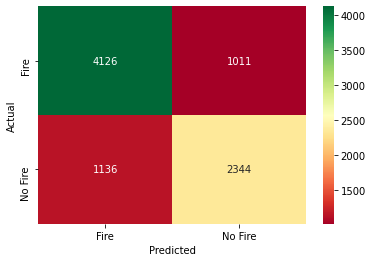

In [ ]:
con = confusion_matrix(test_resize.classes, Y_pred)
con
sns.heatmap(con, cmap="RdYlGn", annot=True, fmt='g', xticklabels=('Fire', 'No Fire'), yticklabels=('Fire', 'No Fire'))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:

#Create table of accuracies 
model_comparison = pd.DataFrame({
    'Model' : ['ResNet50', 'ResNet101V2', 'VGG16', 'Target Model'],
    'Accuracy Score (%)' : [round(ResNet50_results[1]*100,2), round(ResNet101v2_results[1]*100,2), round(vgg16_results[1]*100,2), 76.23]
})
Model_comparison_df = model_comparison.sort_values(by='Accuracy Score (%)', ascending=False)
# Model_comparison_df = Model_comparison_df.set_index('Accuracy Score (%)')
# Model_comparison_df.reset_index()

#create table of results
fig =  ff.create_table(Model_comparison_df)
fig.update_layout(
    autosize=False,
    width=500,
    height=200,
)
fig.show()
